In [1]:
# imports
import numpy as np
import pandas as pd
from subgroup_detection import *
from subgroup_experiment import *
from agglomerative_subgroups import get_parkinsons_dataset, get_ccle_data, \
    get_performance_data, get_temperature_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI, AloRFPlusMDI
from scipy import cluster
from scipy.cluster.hierarchy import fcluster, cut_tree
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, \
    accuracy_score, r2_score, f1_score, log_loss, root_mean_squared_error
from imodels import get_clean_dataset
import openml
from ucimlrepo import fetch_ucirepo

In [2]:
ids = [361247, 361243, 361242, 361251, 361253, 361260, 361259, 361256, 361254, 361622]


In [3]:
task = openml.tasks.get_task(ids[0])
dataset = task.get_dataset()
X, y, _, cols = dataset.get_data(target=dataset.default_target_attribute,dataset_format="array")
# set X to first 2000 rows of X
X = X[:2000]
y = y[:2000]

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: FutureWarning: Starting from Version 0.15.0 `download_splits` will default to ``False`` instead of ``True`` and be independent from `download_data`. To disable this message until version 0.15 explicitly set `download_splits` to a bool.
  exec(code_obj, self.user_global_ns, self.user_ns)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/openml/tasks/functions.py:442: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  dataset = get_dataset(task.dataset_id, *dataset_args, **get_dataset_kwargs)
/scratch/users/zachrewolinski/conda/envs/mdi/lib/pytho

In [4]:
# get the data
# X, y, cols = get_clean_dataset(dataset_name = ids[1], data_source='openml')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)
# discern if the task is classification or regression
if len(np.unique(y)) == 2:
    task = 'classification'
else:
    task = 'regression'
    # convert y to float, if it is not already (ints will cause errors)
    y = y.astype(float)

In [5]:
def fit_models(X_train, y_train, task):
    # fit models
    if task == "classification":
        rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=3,
                                    max_features='sqrt', random_state=42)
        rf.fit(X_train, y_train)
        rf_plus_baseline = RandomForestPlusClassifier(rf_model=rf,
                                        include_raw=False, fit_on="inbag",
                                        prediction_model=LogisticRegression())
        rf_plus_baseline.fit(X_train, y_train)
        rf_plus = RandomForestPlusClassifier(rf_model=rf)
        rf_plus.fit(X_train, y_train)
    elif task == "regression":
        rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=5,
                                   max_features=0.33, random_state=42)
        rf.fit(X_train, y_train)
        rf_plus_baseline = RandomForestPlusRegressor(rf_model=rf,
                                        include_raw=False, fit_on="inbag",
                                        prediction_model=LinearRegression())
        rf_plus_baseline.fit(X_train, y_train)
        rf_plus = RandomForestPlusRegressor(rf_model=rf)
        rf_plus.fit(X_train, y_train)
    else:
        raise ValueError("Task must be either 'classification' or 'regression'.")
    return rf, rf_plus_baseline, rf_plus

In [6]:
rf, rf_plus_baseline, rf_plus = fit_models(X_train, y_train, task)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 71 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 76 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller value

In [7]:
def get_shap(X, shap_explainer, task):
    if task == "classification":
        # the shap values are an array of shape
        # (# of samples, # of features, # of classes), and in this binary
        # classification case, we want the shap values for the positive class.
        # check_additivity=False is used to speed up computation.
        shap_values = \
            shap_explainer.shap_values(X, check_additivity=False)[:, :, 1]
    else:
        # check_additivity=False is used to speed up computation.
        shap_values = shap_explainer.shap_values(X, check_additivity=False)
    # get the rankings of the shap values. negative absolute value is taken
    # because np.argsort sorts from smallest to largest.
    shap_rankings = np.argsort(-np.abs(shap_values), axis = 1)
    return shap_values, shap_rankings

In [8]:
shap_explainer = shap.TreeExplainer(rf)
shap_values, shap_rankings = get_shap(X_train, shap_explainer, task)

In [9]:
def get_lmdi(X, y, lmdi_explainer, l2norm, sign, normalize, leaf_average, ranking=False):
    # get feature importances
    lmdi = lmdi_explainer.explain_linear_partial(X, y, l2norm=l2norm, sign=sign,
                                                 normalize=normalize,
                                                 leaf_average=leaf_average,
                                                 ranking=ranking)
    mdi_rankings = lmdi_explainer.get_rankings(np.abs(lmdi))
    return lmdi, mdi_rankings

In [10]:
lmdi_explainer_signed_normalized_l2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_normalized_l2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_nonnormalized_l2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_signed_nonnormalized_l2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_avg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_noavg = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_l2_ranking_nonloo = RFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonl2_ranking_nonloo = RFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_normalized_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_explainer_nonnormalized_l2_ranking = AloRFPlusMDI(rf_plus, mode = "only_k")
lmdi_baseline_explainer = RFPlusMDI(rf_plus_baseline, mode = "only_k", evaluate_on = "inbag")
lmdi_values_signed_normalized_l2_avg, \
    lmdi_rankings_signed_normalized_l2_avg = \
        get_lmdi(X_train, y_train, lmdi_explainer_signed_normalized_l2_avg,
                    l2norm=True, sign=True, normalize=True, leaf_average=True)
lmdi_values_signed_normalized_l2_noavg, \
    lmdi_rankings_signed_normalized_l2_noavg = \
        get_lmdi(X_train, y_train,lmdi_explainer_signed_normalized_l2_noavg,
                    l2norm=True, sign=True, normalize=True, leaf_average=False)
lmdi_values_signed_nonnormalized_l2_avg, \
    lmdi_rankings_signed_nonnormalized_l2_avg = \
        get_lmdi(X_train,y_train,lmdi_explainer_signed_nonnormalized_l2_avg,
                    l2norm=True, sign=True, normalize=False, leaf_average=True)
lmdi_values_signed_nonnormalized_l2_noavg, \
    lmdi_rankings_signed_nonnormalized_l2_noavg = \
        get_lmdi(X_train, y_train,
                    lmdi_explainer_signed_nonnormalized_l2_noavg, l2norm=True,
                    sign=True, normalize=False, leaf_average=False)
lmdi_values_nonl2_avg, lmdi_rankings_nonl2_avg = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_avg, l2norm=False,
                sign=False, normalize=False, leaf_average=True)
lmdi_values_nonl2_noavg, lmdi_rankings_nonl2_noavg = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_noavg, l2norm=False,
                sign=False, normalize=False, leaf_average=False)
lmdi_values_l2_ranking, lmdi_rankings_l2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_l2_ranking, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_nonl2_ranking, lmdi_rankings_nonl2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_ranking, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_l2_ranking_nonloo, lmdi_rankings_l2_ranking_nonloo = \
    get_lmdi(X_train, y_train, lmdi_explainer_l2_ranking_nonloo, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_nonl2_ranking_nonloo, lmdi_rankings_nonl2_ranking_nonloo = \
    get_lmdi(X_train, y_train, lmdi_explainer_nonl2_ranking_nonloo, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
lmdi_values_normalized_l2_ranking, lmdi_rankings_normalized_l2_ranking = \
    get_lmdi(X_train, y_train, lmdi_explainer_normalized_l2_ranking, l2norm=True,
                sign=False, normalize=True, leaf_average=False, ranking=True)
lmdi_values_baseline, lmdi_rankings_baseline = \
    get_lmdi(X_train, y_train, lmdi_baseline_explainer, l2norm=False,
                sign=False, normalize=False, leaf_average=False)

In [11]:
# create storage for iteration purposes
lfi_values = \
    {'shap': shap_values,
        # 'signed_normalized_l2_avg': lmdi_values_signed_normalized_l2_avg,
        # 'signed_normalized_l2_noavg': lmdi_values_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_values_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_values_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_values_nonl2_avg,
        'nonl2_noavg': lmdi_values_nonl2_noavg,
        'l2_ranking': lmdi_values_l2_ranking,
        'nonl2_ranking': lmdi_values_nonl2_ranking,
        'l2_ranking_nonloo': lmdi_values_l2_ranking_nonloo,
        'nonl2_ranking_nonloo': lmdi_values_nonl2_ranking_nonloo,
        # 'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
        # 'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': lmdi_values_baseline}
lfi_rankings = \
    {'shap': shap_rankings,
        'signed_normalized_l2_avg': lmdi_rankings_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': lmdi_rankings_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': lmdi_rankings_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            lmdi_rankings_signed_nonnormalized_l2_noavg,
        'nonl2_avg': lmdi_rankings_nonl2_avg,
        'nonl2_noavg': lmdi_rankings_nonl2_noavg,
        'l2_ranking': lmdi_rankings_l2_ranking,
        'nonl2_ranking': lmdi_rankings_nonl2_ranking,
    #  'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
    #  'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': lmdi_rankings_baseline}

In [12]:
test_shap_values, test_shap_rankings = get_shap(X_test, shap_explainer, task)
test_lmdi_values_signed_normalized_l2_avg, \
    test_lmdi_rankings_signed_normalized_l2_avg = \
        get_lmdi(X_test, None, lmdi_explainer_signed_normalized_l2_avg,
                    l2norm=True, sign=True, normalize=True, leaf_average=True)
test_lmdi_values_signed_normalized_l2_noavg, \
    test_lmdi_rankings_signed_normalized_l2_noavg = \
        get_lmdi(X_test, None,lmdi_explainer_signed_normalized_l2_noavg,
                    l2norm=True, sign=True, normalize=True, leaf_average=False)
test_lmdi_values_signed_nonnormalized_l2_avg, \
    test_lmdi_rankings_signed_nonnormalized_l2_avg = \
        get_lmdi(X_test, None,lmdi_explainer_signed_nonnormalized_l2_avg,
                    l2norm=True, sign=True, normalize=False, leaf_average=True)
test_lmdi_values_signed_nonnormalized_l2_noavg, \
    test_lmdi_rankings_signed_nonnormalized_l2_noavg = \
        get_lmdi(X_test, None,
                    lmdi_explainer_signed_nonnormalized_l2_noavg, l2norm=True,
                    sign=True, normalize=False, leaf_average=False)
test_lmdi_values_nonl2_avg, test_lmdi_rankings_nonl2_avg = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_avg, l2norm=False,
                sign=False, normalize=False, leaf_average=True)
test_lmdi_values_nonl2_noavg, test_lmdi_rankings_nonl2_noavg = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_noavg, l2norm=False,
                sign=False, normalize=False, leaf_average=False)
test_lmdi_values_l2_ranking, test_lmdi_rankings_l2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_l2_ranking, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_nonl2_ranking, test_lmdi_rankings_nonl2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_ranking, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_l2_ranking_nonloo, test_lmdi_rankings_l2_ranking_nonloo = \
    get_lmdi(X_test, None, lmdi_explainer_l2_ranking_nonloo, l2norm=True,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_nonl2_ranking_nonloo, test_lmdi_rankings_nonl2_ranking_nonloo = \
    get_lmdi(X_test, None, lmdi_explainer_nonl2_ranking_nonloo, l2norm=False,
                sign=False, normalize=False, leaf_average=False, ranking=True)
test_lmdi_values_normalized_l2_ranking, test_lmdi_rankings_normalized_l2_ranking = \
    get_lmdi(X_test, None, lmdi_explainer_normalized_l2_ranking, l2norm=True,
                sign=False, normalize=True, leaf_average=False, ranking=True)
test_lmdi_values_baseline, test_lmdi_rankings_baseline = \
    get_lmdi(X_test, None, lmdi_baseline_explainer, l2norm=False,
                sign=False, normalize=False, leaf_average=False)

In [13]:
# create storage for iteration purposes
test_lfi_values = \
    {'shap': test_shap_values,
        # 'signed_normalized_l2_avg': test_lmdi_values_signed_normalized_l2_avg,
        # 'signed_normalized_l2_noavg': test_lmdi_values_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': test_lmdi_values_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            test_lmdi_values_signed_nonnormalized_l2_noavg,
        'nonl2_avg': test_lmdi_values_nonl2_avg,
        'nonl2_noavg': test_lmdi_values_nonl2_noavg,
        'l2_ranking': test_lmdi_values_l2_ranking,
        'nonl2_ranking': test_lmdi_values_nonl2_ranking,
        'l2_ranking_nonloo': test_lmdi_values_l2_ranking_nonloo,
        'nonl2_ranking_nonloo': test_lmdi_values_nonl2_ranking_nonloo,
        # 'normalized_l2_ranking': test_lmdi_values_normalized_l2_ranking,
        # 'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': test_lmdi_values_baseline}
test_lfi_rankings = \
    {'shap': test_shap_rankings,
        'signed_normalized_l2_avg': test_lmdi_rankings_signed_normalized_l2_avg,
        'signed_normalized_l2_noavg': test_lmdi_rankings_signed_normalized_l2_noavg,
        'signed_nonnormalized_l2_avg': test_lmdi_rankings_signed_nonnormalized_l2_avg,
        'signed_nonnormalized_l2_noavg':
            test_lmdi_rankings_signed_nonnormalized_l2_noavg,
        'nonl2_avg': test_lmdi_rankings_nonl2_avg,
        'nonl2_noavg': test_lmdi_rankings_nonl2_noavg,
        'l2_ranking': test_lmdi_rankings_l2_ranking,
        'nonl2_ranking': test_lmdi_rankings_nonl2_ranking,
    #  'normalized_l2_ranking': lmdi_values_normalized_l2_ranking,
    #  'normalized_nonl2_ranking': lmdi_values_normalized_nonl2_ranking,
        'baseline': test_lmdi_rankings_baseline}

In [14]:
values_linkage = {}
for method, values in lfi_values.items():
    # values_linkage[method] = sch.linkage(values, method="ward")
    values_linkage[method] = cluster.hierarchy.ward(values)

In [15]:
# get clusters for values
value_clusters = {}
for method, link in values_linkage.items():
    num_cluster_map = {}
    for num_clusters in range(2, 11):
        
        # num_cluster_map[num_clusters] = fcluster(link, num_clusters,
        #                                          criterion = "maxclust")
        num_cluster_map[num_clusters] = cut_tree(link, n_clusters=num_clusters).flatten()
    value_clusters[method] = num_cluster_map
print(value_clusters)

{'shap': {2: array([0, 0, 0, ..., 1, 1, 1]), 3: array([0, 1, 1, ..., 2, 2, 2]), 4: array([0, 1, 1, ..., 3, 2, 2]), 5: array([0, 1, 1, ..., 4, 2, 2]), 6: array([0, 1, 1, ..., 4, 2, 2]), 7: array([0, 1, 1, ..., 4, 2, 2]), 8: array([0, 1, 1, ..., 4, 2, 2]), 9: array([0, 1, 1, ..., 5, 2, 2]), 10: array([0, 1, 1, ..., 6, 2, 2])}, 'signed_nonnormalized_l2_avg': {2: array([0, 0, 0, ..., 1, 1, 1]), 3: array([0, 0, 0, ..., 2, 1, 1]), 4: array([0, 0, 0, ..., 2, 1, 1]), 5: array([0, 0, 0, ..., 2, 1, 3]), 6: array([0, 0, 0, ..., 5, 1, 3]), 7: array([0, 0, 0, ..., 5, 1, 3]), 8: array([0, 0, 0, ..., 6, 2, 4]), 9: array([0, 1, 1, ..., 7, 3, 5]), 10: array([0, 1, 1, ..., 7, 3, 9])}, 'signed_nonnormalized_l2_noavg': {2: array([0, 0, 0, ..., 1, 1, 1]), 3: array([0, 0, 0, ..., 2, 1, 1]), 4: array([0, 0, 0, ..., 2, 1, 1]), 5: array([0, 0, 0, ..., 2, 1, 3]), 6: array([0, 0, 0, ..., 5, 1, 3]), 7: array([0, 0, 0, ..., 5, 1, 3]), 8: array([0, 0, 0, ..., 6, 2, 4]), 9: array([0, 0, 1, ..., 7, 3, 5]), 10: array(

In [16]:
# for each method, for each number of clusters, get the clusters and compute their centroids
value_centroids = {}
for method, clusters in value_clusters.items():
    num_cluster_centroids = {}
    for num_clusters, cluster_labels in clusters.items():
        centroids = np.zeros((num_clusters, X.shape[1]))
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_values = lfi_values[method][cluster_indices]
            centroids[cluster_num] = np.mean(cluster_values, axis = 0)
        num_cluster_centroids[num_clusters] = centroids
    value_centroids[method] = num_cluster_centroids
print(value_centroids)

{'shap': {2: array([[ 5.32397692e-06,  2.11564183e-05,  2.08440973e-04,
         9.12406398e-05, -1.73524018e-04,  5.33773100e-05,
         7.21128906e-05, -9.89228929e-05, -4.60919557e-04,
         6.09285327e-04,  2.47285371e-04,  1.81653603e-05,
         5.40365442e-05, -1.92819126e-05],
       [-3.23548485e-06, -8.63135300e-07, -1.37471524e-04,
        -1.06553301e-05,  4.12407166e-05, -4.87868590e-05,
        -3.93721746e-05,  7.31503715e-05,  1.78502468e-04,
        -3.40333915e-04, -1.34303613e-04, -1.90701508e-05,
        -2.75053676e-05,  6.25511390e-07]]), 3: array([[ 9.43989792e-06,  2.72721381e-05,  2.21856648e-04,
         2.01702625e-04,  1.41118545e-05,  6.90535627e-05,
         8.26343174e-05,  1.83869577e-05, -1.11132239e-04,
         7.47425661e-04,  3.04608070e-04,  2.11239756e-05,
         1.38727185e-04,  3.13072418e-05],
       [-2.14916997e-06,  1.00523004e-05,  1.84082558e-04,
        -1.09321674e-04, -5.14208505e-04,  2.49144365e-05,
         5.30094705e-05, -3

In [17]:
# for each method, for its test values, assign the test values to the closest centroid
test_value_clusters = {}
for method, centroids in value_centroids.items():
    num_cluster_map = {}
    for num_clusters, centroid_values in centroids.items():
        test_clusters = np.zeros(len(test_lfi_values[method]))
        for i, test_value in enumerate(test_lfi_values[method]):
            distances = np.linalg.norm(centroid_values - test_value, axis = 1)
            test_clusters[i] = np.argmin(distances)
        num_cluster_map[num_clusters] = test_clusters
    test_value_clusters[method] = num_cluster_map

In [18]:
# using original data, split train and test set into clusters according to each method
train_clusters = {}
for method, clusters in value_clusters.items():
    num_cluster_map = {}
    for num_clusters, cluster_labels in clusters.items():
        cluster_map = {}
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_map[cluster_num] = cluster_indices
        num_cluster_map[num_clusters] = cluster_map
    train_clusters[method] = num_cluster_map
test_clusters = {}
for method, clusters in test_value_clusters.items():
    num_cluster_map = {}
    for num_clusters, cluster_labels in clusters.items():
        cluster_map = {}
        for cluster_num in range(num_clusters):
            cluster_indices = np.where(cluster_labels == cluster_num)[0]
            cluster_map[cluster_num] = cluster_indices
        num_cluster_map[num_clusters] = cluster_map
    test_clusters[method] = num_cluster_map
print(train_clusters)

{'shap': {2: {0: array([   0,    1,    2,    5,    8,   10,   13,   14,   17,   20,   21,
         25,   28,   29,   30,   32,   36,   43,   44,   45,   52,   53,
         56,   57,   65,   67,   69,   70,   71,   76,   77,   79,   83,
         85,   86,   87,   89,   93,   94,   95,   97,  101,  102,  105,
        111,  114,  120,  121,  123,  124,  127,  129,  130,  135,  138,
        139,  141,  147,  148,  150,  151,  155,  158,  160,  161,  164,
        165,  168,  171,  173,  174,  176,  177,  179,  182,  183,  187,
        188,  189,  190,  191,  194,  197,  198,  199,  200,  201,  202,
        204,  207,  208,  210,  212,  214,  215,  216,  217,  219,  220,
        227,  232,  234,  237,  238,  240,  246,  247,  251,  255,  262,
        271,  272,  276,  280,  282,  283,  285,  287,  288,  289,  290,
        291,  293,  296,  297,  299,  301,  302,  303,  306,  309,  313,
        318,  319,  320,  324,  327,  328,  329,  331,  333,  335,  339,
        340,  341,  342,  343,  34

In [19]:
train_clusters

{'shap': {2: {0: array([   0,    1,    2,    5,    8,   10,   13,   14,   17,   20,   21,
            25,   28,   29,   30,   32,   36,   43,   44,   45,   52,   53,
            56,   57,   65,   67,   69,   70,   71,   76,   77,   79,   83,
            85,   86,   87,   89,   93,   94,   95,   97,  101,  102,  105,
           111,  114,  120,  121,  123,  124,  127,  129,  130,  135,  138,
           139,  141,  147,  148,  150,  151,  155,  158,  160,  161,  164,
           165,  168,  171,  173,  174,  176,  177,  179,  182,  183,  187,
           188,  189,  190,  191,  194,  197,  198,  199,  200,  201,  202,
           204,  207,  208,  210,  212,  214,  215,  216,  217,  219,  220,
           227,  232,  234,  237,  238,  240,  246,  247,  251,  255,  262,
           271,  272,  276,  280,  282,  283,  285,  287,  288,  289,  290,
           291,  293,  296,  297,  299,  301,  302,  303,  306,  309,  313,
           318,  319,  320,  324,  327,  328,  329,  331,  333,  335,  339

In [20]:
test_clusters

{'shap': {2: {0: array([  0,  11,  13,  15,  16,  18,  19,  20,  21,  24,  30,  31,  33,
           36,  38,  40,  42,  45,  47,  48,  49,  55,  57,  58,  60,  64,
           66,  70,  74,  78,  80,  82,  83,  84,  85,  86,  90,  94,  95,
           98,  99, 100, 102, 104, 105, 106, 108, 110, 111, 112, 113, 116,
          120, 123, 124, 125, 128, 129, 130, 132, 133, 135, 136, 137, 138,
          139, 140, 143, 145, 146, 147, 148, 150, 151, 153, 156, 157, 158,
          161, 164, 165, 172, 174, 176, 179, 184, 187, 190, 192, 193, 196,
          206, 209, 213, 214, 215, 221, 225, 228, 229, 230, 237, 240, 242,
          243, 244, 245, 248, 249, 250, 251, 257, 258, 259, 260, 261, 262,
          263, 264, 265, 271, 276, 278, 280, 281, 284, 285, 290, 294, 300,
          302, 304, 306, 307, 312, 319, 320, 321, 322, 323, 325, 326, 328,
          330, 331, 332, 333, 335, 336, 339, 340, 342, 345, 346, 347, 348,
          349, 351, 352, 353, 354, 357, 359, 360, 361, 362, 364, 367, 368,
          3

In [21]:
# for each method, for each number of clusters, train a linear model on the training set for each cluster and use it to predict the testing set for each cluster
train_test_accuracies = {}
train_test_r2 = {}
for method in train_clusters.keys():
    method_accuracies = {}
    method_r2s = {}
    for num_clusters in range(2, 11):
        r2 = []
        accuracy = []
        num_samples = []
        for cluster_idx in range(num_clusters):
            X_cluster_train = X_train[train_clusters[method][num_clusters][cluster_idx]]
            y_cluster_train = y_train[train_clusters[method][num_clusters][cluster_idx]]
            X_cluster_test = X_test[test_clusters[method][num_clusters][cluster_idx]]
            y_cluster_test = y_test[test_clusters[method][num_clusters][cluster_idx]]
            if X_cluster_test.shape[0] == 0:
                continue
            if task == "classification":
                model = LogisticRegression()
            else:
                model = LinearRegression()
            model.fit(X_cluster_train, y_cluster_train)
            cluster_predictions = model.predict(X_cluster_test)
            # get model accuracy
            if task == "classification":
                accuracy.append(accuracy_score(y_cluster_test, cluster_predictions))
            else:
                rmse = root_mean_squared_error(y_cluster_test, cluster_predictions)
                print(f"RMSE for {method} w/ Cluster {cluster_idx+1}/{num_clusters} is {rmse}.")
                accuracy.append(root_mean_squared_error(y_cluster_test, cluster_predictions))
                r2.append(r2_score(y_cluster_test, cluster_predictions))
            num_samples.append(X_cluster_test.shape[0])
        method_accuracies[num_clusters] = weighted_metric(np.array(accuracy), np.array(num_samples))
        method_r2s[num_clusters] = weighted_metric(np.array(r2), np.array(num_samples))
    # average accuracy across clusters
    train_test_accuracies[method] = method_accuracies
    train_test_r2[method] = method_r2s

RMSE for shap w/ Cluster 1/2 is 0.0011445284932732054.
RMSE for shap w/ Cluster 2/2 is 0.0009922498157503208.
RMSE for shap w/ Cluster 1/3 is 0.027281400903993308.
RMSE for shap w/ Cluster 2/3 is 0.009942837383779714.
RMSE for shap w/ Cluster 3/3 is 0.000994189767380801.
RMSE for shap w/ Cluster 1/4 is 0.0009196394707618619.
RMSE for shap w/ Cluster 2/4 is 5.560614551822814e-05.
RMSE for shap w/ Cluster 3/4 is 0.011793098028449795.
RMSE for shap w/ Cluster 4/4 is 0.03515880072413344.
RMSE for shap w/ Cluster 1/5 is 6.491663718862225e-05.
RMSE for shap w/ Cluster 2/5 is 5.458092742669756e-05.
RMSE for shap w/ Cluster 3/5 is 0.004552416992647418.
RMSE for shap w/ Cluster 4/5 is 0.02673274375572193.
RMSE for shap w/ Cluster 5/5 is 0.03579808908925724.
RMSE for shap w/ Cluster 1/6 is 6.491663718862225e-05.
RMSE for shap w/ Cluster 2/6 is 5.458092742669756e-05.
RMSE for shap w/ Cluster 3/6 is 0.007584884108137434.
RMSE for shap w/ Cluster 4/6 is 0.0004192880871736979.
RMSE for shap w/ Clust

In [22]:
train_test_accuracies

{'shap': {2: 0.001063566996390205,
  3: 0.010287895218726225,
  4: 0.011402248788514454,
  5: 0.012815270832654635,
  6: 0.002421849584726523,
  7: 0.06714166605813691,
  8: 0.06352477539496658,
  9: 0.06178932493595845,
  10: 0.044841594882506094},
 'signed_nonnormalized_l2_avg': {2: 0.0018733478096973981,
  3: 0.0006295778759588217,
  4: 0.00032821770203920753,
  5: 0.0002800411026586456,
  6: 8.047123661835767e-05,
  7: 7.193348382505217e-05,
  8: 5.253929422661858e-05,
  9: 5.253893681163271e-05,
  10: 4.495191896992557e-05},
 'signed_nonnormalized_l2_noavg': {2: 0.0018733478096973981,
  3: 0.0006295778759588217,
  4: 0.00032821770203920753,
  5: 0.00027766315453139684,
  6: 7.809328849110889e-05,
  7: 6.955553569780338e-05,
  8: 5.1552649249988173e-05,
  9: 5.156205337523968e-05,
  10: 4.289553372192402e-05},
 'nonl2_avg': {2: 0.0004654992174119125,
  3: 0.002864276499904663,
  4: 0.00013335811112321705,
  5: 0.00012209773735338787,
  6: 0.00012199149322725056,
  7: 0.000119121425

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


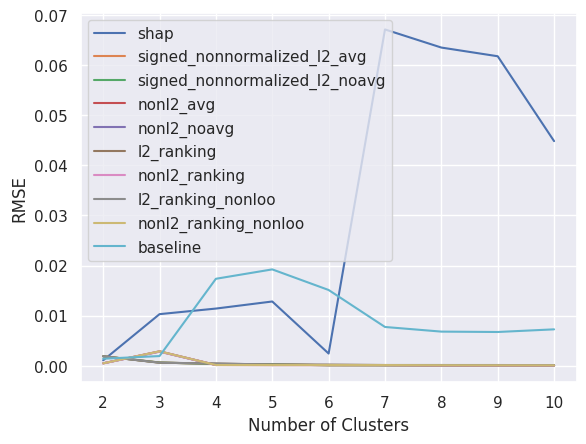

In [23]:
# plot the results such that each line has a unique color
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
for method, predictions in train_test_accuracies.items():
    ax.plot(list(predictions.keys()), list(predictions.values()), label = method)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("RMSE")
ax.legend()
plt.show()

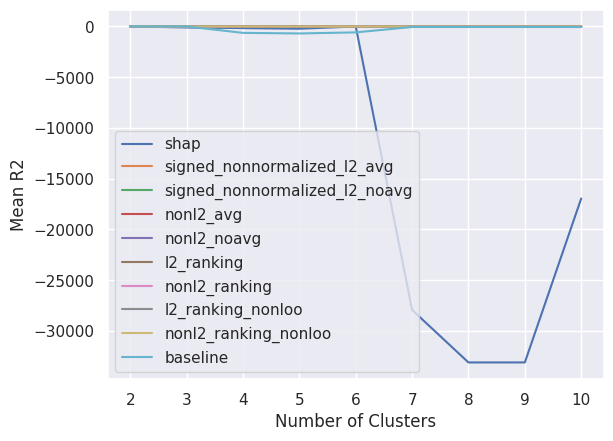

In [24]:
# plot the results such that each line has a unique color
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
fig, ax = plt.subplots()
for method, predictions in train_test_r2.items():
    ax.plot(list(predictions.keys()), list(predictions.values()), label = method)
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Mean R2")
ax.legend()
plt.show()

In [25]:
# import matplotlib.pyplot as plt
# for method, predictions in train_test_predictions.items():
#     if method == "l2_ranking":
#         continue
#     plt.plot(list(predictions.keys()), list(predictions.values()), label = method)
# plt.xlabel("Number of Clusters")
# plt.ylabel("Average Accuracy")
# plt.legend()
# plt.show()